In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from src.rover_sim.rover_updated import *
from src.rover_sim.terrain import *

In [3]:
# Set up ALPaCA

%load_ext autoreload
%autoreload 2

# Can change to arbitrary dynamics object, as long as the model being loaded corresponds to it
from src.envs.rocker_bogie_with_terrain_simplified import RockerBogieDynamics as Dynamics
from src.envs.rocker_bogie_with_terrain_simplified import state_space, action_space

from src.models import Alpaca, AlpacaDynamics
from src.models.dataset import DynamicsRandomDataset

from src.utils.validation import single_action

In [4]:
# create ground truth dynamics to compare to
dynamics = Dynamics()
dynamics.seed(1234)

c rand
phi rand


[1234]

In [5]:

### WITH NOMINAL MODEL broken up (simplified) only velocity - orthogonal loss term
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)

# Strength = 0 
filename = './trained_models/rocker_bogie_orion0'
model_0 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_0 = AlpacaDynamics(model_0, f_nom=fnom)
dyn_fn_alpaca_0 = alpaca_model_0.get_model(modeltype=alpaca_model_0.ModelType.POSTERIOR_PREDICTIVE)

# Strength = 3e-5
filename = './trained_models/rocker_bogie_orionneg5'
model_neg5 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg5 = AlpacaDynamics(model_neg5, f_nom=fnom)
dyn_fn_alpaca_neg5 = alpaca_model_neg5.get_model(modeltype=alpaca_model_neg5.ModelType.POSTERIOR_PREDICTIVE)

# Strength = 3e-4
filename = './trained_models/rocker_bogie_orionneg4'
model_neg4 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg4 = AlpacaDynamics(model_neg4, f_nom=fnom)
dyn_fn_alpaca_neg4 = alpaca_model_neg4.get_model(modeltype=alpaca_model_neg4.ModelType.POSTERIOR_PREDICTIVE)

# Strength = 1/300 = 3e-3
filename = './trained_models/rocker_bogie_orionneg3'
model_neg3 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg3 = AlpacaDynamics(model_neg3, f_nom=fnom)
dyn_fn_alpaca_neg3 = alpaca_model_neg3.get_model(modeltype=alpaca_model_neg3.ModelType.POSTERIOR_PREDICTIVE)

# Strength = 1/30 = 3e-2
filename = './trained_models/rocker_bogie_orionneg2'
model_neg2 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg2 = AlpacaDynamics(model_neg2, f_nom=fnom)
dyn_fn_alpaca_neg2 = alpaca_model_neg2.get_model(modeltype=alpaca_model_neg2.ModelType.POSTERIOR_PREDICTIVE)

# Strength = 1/3 = 3e-1
filename = './trained_models/rocker_bogie_orionneg1'
model_neg1 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg1 = AlpacaDynamics(model_neg1, f_nom=fnom)
dyn_fn_alpaca_neg1 = alpaca_model_neg1.get_model(modeltype=alpaca_model_neg1.ModelType.POSTERIOR_PREDICTIVE)

# Strength =  3e0
filename = './trained_models/rocker_bogie_orionneg0'
model_neg0 = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_neg0 = AlpacaDynamics(model_neg0, f_nom=fnom)
dyn_fn_alpaca_neg0 = alpaca_model_neg0.get_model(modeltype=alpaca_model_neg0.ModelType.POSTERIOR_PREDICTIVE)

loading state dict
loading state dict
loading state dict
loading state dict
loading state dict
loading state dict
loading state dict


In [6]:
models = [alpaca_model_0, alpaca_model_neg5, alpaca_model_neg4,  alpaca_model_neg3, alpaca_model_neg2, alpaca_model_neg1, alpaca_model_neg0]

In [7]:
labels = ["0","3.3e-5", "3.3e-4","3.3e-3", "3.3e-2", "3.3e-1", "3.3e0"]


# Estimate terrain parameters

In [8]:
state_init = np.array([0.0]) # [vel]
prev_slips = np.array([0.001,0.001,0.001])
prev_sinkages = np.array([0.02,0.02,0.02])

dt = 0.1
# These params shouldn't change
# Loose Sand parameters
n = 1.1; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.025; c1 = 0.18; c2 = 0.32 
# Compact sand
# n = 0.47; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.038; c1 = 0.43; c2 = 0.32

c_placeholder = 0.9e3 
phi_placeholder = np.deg2rad(30) 
terr_params = [c_placeholder, phi_placeholder, n, k, k_c, k_phi, n, c1, c2] 

In [9]:
def plot_estimates(true_params_list, list_of_params_lists, list_of_vars_lists, labels = None):
    num_lists = np.shape(list_of_params_lists)[-1]

    num_sim_steps = true_params_list.shape[0]
    times = 0.1*np.arange(num_sim_steps+1)

    # fig = plt.figure(figsize= plt.figaspect(0.2))
    fig = plt.figure(figsize= (15,5))
    plt.rcParams.update({'font.size': 14})

    ax1 = fig.add_subplot(121)
    ax1.plot(times[:-1], true_params_list[:,0],'--', color = 'black', label='True')
    for i in range(num_lists):
        this_model_params = list_of_params_lists[:,:,i]
        this_model_vars = list_of_vars_lists[:,:,:,i]
        if labels == None:
            lbl = ''
        else:
            lbl = labels[i]
        clr = 'C{}'
        ax1.plot(times, 1000*this_model_params[:,0], color = clr.format(str(i)),  label =lbl)
        ax1.fill_between(times,1000*(this_model_params[:,0] - 1.96/np.sqrt(this_model_vars[:,0,0])), 1000*(this_model_params[:,0] + 1.96/np.sqrt(this_model_vars[:,0,0])),color = clr.format(str(i)),  alpha=0.4)    

    ax1.set(title = 'Cohesion (c)', xlabel = 'Sim time', ylabel = '[Pa]')
    ax1.legend(loc = 'best')
    ax1.grid()


    ax2 = fig.add_subplot(122)
    ax2.plot(times[:-1], true_params_list[:,1]*180/np.pi,'--', color = 'black', label='True')
    for i in range(num_lists):
        this_model_params = list_of_params_lists[:,:,i]
        this_model_vars = list_of_vars_lists[:,:,:,i]
        if labels == None:
            lbl = ''
        else:
            lbl = labels[i]
        ax2.plot(times, 1000*this_model_params[:,1],  label =lbl)
        ax2.fill_between(times,1000*(this_model_params[:,1] - 1.96/np.sqrt(this_model_vars[:,1,1])), 1000*(this_model_params[:,1] + 1.96/np.sqrt(this_model_vars[:,1,1])), alpha=0.4)    

    ax2.set(title = 'Angle of internal friction (phi)', xlabel = 'Sim time', ylabel = '[Deg]')
    ax2.legend(loc = 'best')
    ax2.grid() 

    plt.show()

In [10]:
def do_estimation_noisy(terr_params_true, models):
    num_models = len(models)
    num_sim_steps = 400
    [_, _, n, k, k_c, k_phi, n, c1, c2] = terr_params_true

    # loose sand
    n_lin = 1.0; k_c_lin = 1.1e3; k_phi_lin = 1515e3; k_lin = 0.025; c1_lin = 0.33; c2_lin = 0.32 
    # compact sand
    # n_lin = 0.47; k_c_lin = 0.9e3; k_phi_lin = 1523.4e3; k_lin = 0.038; c1_lin = 0.43; c2_lin = 0.32

    terr_params_for_est = [0, 0, n_lin, k_lin, k_c_lin, k_phi_lin, n_lin, c1_lin, c2_lin]

    torques_list = dynamics.rover.get_random_torques(num_sim_steps, two_phase=False)

    u_list = np.zeros((num_sim_steps, 6))
    x_list = np.zeros((num_sim_steps+1, 1))
    x_curr = state_init
    x_list[0,:] = state_init
    x_noisy_list = np.zeros((num_sim_steps+1, 1))
    x_noisy_list[0,:] = state_init
    u_noisy_list = np.zeros((num_sim_steps, 6))

    true_params_list = np.vstack([c_true*np.ones(num_sim_steps), phi_true*np.ones(num_sim_steps)]).T

    list_of_params_list = np.zeros((num_sim_steps+1, 2, num_models))
    list_of_var_list = np.zeros((num_sim_steps+1, 2, 2, num_models))
    for i in range(num_models):
        alpaca_model = models[i]
        alpaca_model.reset()
        stats = alpaca_model.model.prior_params()
        Q, L = stats 
        Kbar = (torch.inverse(L) @ Q)
        list_of_params_list[0,:, i] = Kbar.detach().numpy().squeeze()[...,-2:]
        list_of_var_list[0,:, :, i] = L.detach().numpy().squeeze()[...,-2:, -2:]

    for step in range(num_sim_steps):
        # Simulate a step using true params
        full_action = dynamics.rover.get_full_action_vel_only(x_curr, torques_list[step,:], terr_params_true, prev_slips, prev_sinkages)
        u = full_action[3:9]
        xp = dynamics.rover.transition_vel_only(x_curr, u, terr_params_true, dt)

        x_noise = 0.001
        xp_noisy = xp + np.abs(xp)*x_noise*np.random.randn(*xp.shape)
        u_noise = 0.05
        u_noisy = u + np.abs(u)*u_noise*np.random.randn(*u.shape)

        u_list[step,:] = u # slips, sinkage3
        x_list[step+1,:] = xp
        x_noisy_list[step+1,:] = xp_noisy
        u_noisy_list[step,:] = u_noisy

        for i in range(num_models):
            alpaca_model = models[i]
            stats = alpaca_model.incorporate_transition(x_curr,u_noisy,xp_noisy)
            Q, L = stats
            Kbar = (torch.inverse(L) @ Q)
            theta_vals =  Kbar.detach().numpy().squeeze()[...,-2:]
            var_vals = L.detach().numpy().squeeze()[...,-2:, -2:]
            list_of_params_list[step+1,:,i] = theta_vals
            list_of_var_list[step+1,:,:,i] = var_vals

        # Update state and param estimate
        x_curr = xp
    
    return true_params_list, list_of_params_list, list_of_var_list, u_list

In [11]:
# True parameters
c_true = 1.0e3
phi_true = np.deg2rad(30)
terr_params_true = [c_true, phi_true, n, k, k_c, k_phi, n, c1, c2]

true_params_list, list_of_params_list, list_of_var_list, u_list = do_estimation_noisy(terr_params_true, models)



In [12]:
est_error_all_models = np.zeros((len(models)))
est_std_all_models = np.zeros((len(models)))
for i in range(len(models)):
    this_model_mean_c = list_of_params_list[:,0,i]
    average_of_error_c = (np.average(this_model_mean_c[1:]-true_params_list[:,0]))/true_params_list[0,0]
    this_model_std_c = list_of_var_list[:,0,0,i]
    average_of_std_c = np.average(this_model_std_c)

    this_model_mean_phi = list_of_params_list[:,1,i]
    average_of_error_phi = (np.average(this_model_mean_phi[1:]-true_params_list[:,1]))/true_params_list[0,1]
    this_model_std_phi = list_of_var_list[:,1,1,i]
    average_of_std_phi = np.average(this_model_std_phi)

    avg_error = (np.abs(average_of_error_c) + np.abs(average_of_error_phi))/2
    avg_std = (average_of_std_c + average_of_std_phi)/2
    
    est_error_all_models[i] = avg_error
    est_std_all_models[i] = avg_std


# Predict dynamics

In [13]:
def plot_dyn_predictions(xp_true, list_xp_mean, list_xp_std, ax1, show_legend = True, labels = None):
    dt = 0.1
    N_sim_steps = 50

    num_models = np.shape(list_xp_mean)[-1]

    times = dt*np.arange(N_sim_steps)
    ax1.plot(times, xp_true[1:,:] - xp_true[1:,:], '--', color = 'black', label ='True')

    for i in range(num_models):
        this_model_mean = list_xp_mean[:,:,i]
        this_model_std = list_xp_std[:,:,:,i]
        if labels == None:
            lbl = ''
        else:
            lbl = labels[i]
        clr = 'C{}'
        ax1.plot(times, this_model_mean[1:,0]- xp_true[1:,0], color = clr.format(str(i)), label =lbl)
        ax1.fill_between(times, this_model_mean[1:,0]- xp_true[1:,0] - 1.96*this_model_std[1:,0,0], this_model_mean[1:,0]- xp_true[1:,0] + 1.96*this_model_std[1:,0,0], color = clr.format(str(i)), alpha=0.2)

    ax1.set(title = 'Velocity Prediction Error', xlabel = 'Sim time', ylabel = '[mm/s]')
    if show_legend:
        ax1.legend(loc = 'best')
    else:
        ax1.legend().set_visible(False)
    ax1.set_ylim([-0.8,0.5])
    ax1.grid()

    return ax1


In [14]:
def predict_dyn(models):
    num_models = len(models)
    num_sim_steps = 50
    torques_list = rover.get_random_torques(num_sim_steps, two_phase=True)
    # torques_list = 0.9*np.ones((num_sim_steps,3))

    full_action_list = np.zeros((num_sim_steps, 9))
    u_list = np.zeros((num_sim_steps, 6)) # slips and sinks only

    # True model
    xp_true = np.zeros((num_sim_steps+1, 1))
    xp_true[0,:] = state_init

    list_xp_mean = np.zeros((num_sim_steps+1, 1, num_models))
    list_xp_std = np.zeros((num_sim_steps+1, 1, 1, num_models))

    for i in range(num_models):
        alpaca_model = models[i]
        alpaca_model.reset()
        list_xp_mean[0,:,i] = state_init

    # True parameters
    c_true = 1.0e3
    phi_true = np.deg2rad(30)
    terr_params_true = [c_true, phi_true, n, k, k_c, k_phi, n, c1, c2]

    state_curr = state_init
    for step in range(num_sim_steps):
        # Simulate a step using true params
        full_action = rover.get_full_action_vel_only(state_curr, torques_list[step,:], terr_params_true, prev_slips, prev_sinkages)
        u = full_action[3:9]
        u_list[step,:] = u
        state_new = rover.transition_vel_only(state_curr, u, terr_params_true, dt)
        xp_true[step+1,:] = state_new

        noise = 0.01
        state_new_for_alpaca = state_new + noise*np.random.randn(*state_new.shape)

        for i in range(num_models):
            alpaca_model = models[i]
            dyn_fn_alpaca = alpaca_model.get_model(modeltype=alpaca_model.ModelType.POSTERIOR_PREDICTIVE)
            a, b, list_xp_mean[step+1,:, i], list_xp_std[step+1,:,:,i] = single_action(dyn_fn_alpaca, dynamics, state_curr, u)
            stats = alpaca_model.incorporate_transition(state_curr, u, state_new_for_alpaca)

        state_curr = state_new
    return xp_true, list_xp_mean, list_xp_std

In [15]:
rover = makeDefaultRover()
rover.set_terrain(FlatTerrain())

In [16]:
xp_true, list_xp_mean, list_xp_std = predict_dyn(models)

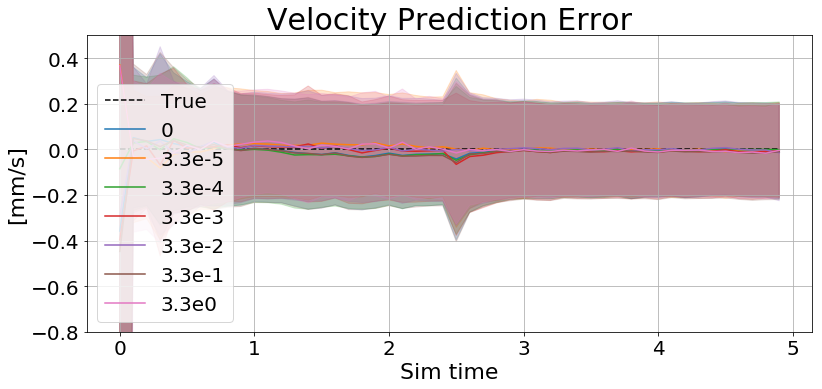

In [17]:
fig = plt.figure(figsize= (13,12))
plt.rcParams.update({'font.size': 20})

plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 22})

ax1 = fig.add_subplot(211)

# labels = ["0 (no nominal model)", "0","3.3e-3", "3.3e-2", "3.3e-1"]
plot_dyn_predictions(xp_true, list_xp_mean, list_xp_std, ax1, show_legend = True, labels = labels)

plt.show()

In [18]:
pred_error_all_models = np.zeros((len(models)))
pred_std_all_models = np.zeros((len(models)))
for i in range(len(models)):
    this_model_mean = list_xp_mean[:,0,i]
    average_of_error = np.average(this_model_mean-xp_true)
    # average_error = average_of_mean - 
    this_model_std = list_xp_std[:,0,0,i]
    average_of_std = np.average(this_model_std)

    pred_error_all_models[i] = np.abs(average_of_error)
    pred_std_all_models[i] = average_of_std


# Plot comparison

In [19]:
import pickle 

In [20]:
filename = './stored_results/range_all_models_est_error_and_std.pickle'
with open(filename, 'rb') as f:
    [est_error_all_models_range, est_std_all_models_range] = pickle.load(f)

In [21]:
filename = './stored_results/range_all_models_pred_error_and_std.pickle'
with open(filename, 'rb') as f:
    [pred_error_all_models_range, pred_std_all_models_range] = pickle.load(f)

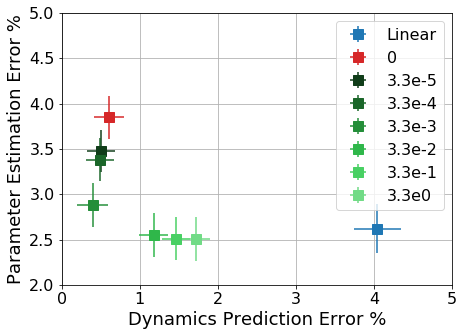

In [22]:
labels = ["Linear","0","3.3e-5", "3.3e-4","3.3e-3", "3.3e-2", "3.3e-1", "3.3e0"]

x = pred_error_all_models_range
xerr = pred_std_all_models_range
# xerr = np.zeros((len(labels)))


y = est_error_all_models_range
yerr = est_std_all_models_range
# yerr = np.zeros((len(labels)))

fig = plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 16})

plt.rcParams.update({'axes.labelsize': 18})

ax1 = fig.add_subplot(111)

from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

color_names = ['tab:red','darkgreen','darkgreen','darkgreen','darkgreen','forestgreen','mediumseagreen']
color_names = ['C0','C1','C2','C3','C4','C5','C6','C7']
color_names = ['tab:blue','tab:red','#103d19','#1a6629','#248e39','#2fb74a','#48d063','#71db86']

for i in range(len(labels)):
    clr = color_names[i]
    ax1.errorbar(x[i],y[i], xerr = xerr[i], yerr = yerr[i], marker = 's', ls = 'none', color = clr, markersize = 10, barsabove = False, label = labels[i])


ax1.grid()
ax1.set(title = '', xlabel = 'Dynamics Prediction Error %', ylabel = 'Parameter Estimation Error %')
ax1.legend(loc='best')
ax1.set_xlim((0.0,5.0))
ax1.set_ylim((2.0,5.0))
# plt.xticks([-0.5, 0.0, 0.5, 1, 1.5])
plt.savefig('./stored_results/orthogonality.png', dpi = 300)

plt.show()